In [1]:
import os
os.chdir('/mnt/jw01-aruk-home01/projects/ra_challenge/RA_challenge/RA2_alpine_lads/ra_joint_predictions')

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from utils.config import Config
import PIL
import json
import logging
import re
import seaborn as sns

In [3]:
configuration = Config()
tf.config.threading.set_intra_op_parallelism_threads(20)
tf.config.threading.set_inter_op_parallelism_threads(20)

In [4]:
# need this to stop that warning
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [5]:
import dataset.combined_joints_dataset as combset
from prediction import joint_damage

In [21]:
def robust_mean(scores):
    scores = np.sort(scores)
    size_p = len(scores)//10
    mean_score = np.mean(scores[size_p:len(scores)-size_p])
    return mean_score
    


In [22]:
%%timeit
robust_mean([0,0,0,1,2,4,5,10,10,10,10,10,10,10,0,2,5,4,1,0,6,9,8,7,4,5,1,2,3,6,5,4,2,5])

16.3 µs ± 181 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [7]:
hands_model = keras.models.load_model("weights/SC1_v3A_hand_narrowingafter_model_50.h5")

In [8]:
test_dataset_class = combset.overall_test_hand(configuration,"/mnt/jw01-aruk-home01/projects/ra_challenge/RA_challenge/training_dataset/fixed", is_test = True)
test_data = test_dataset_class.create_generator(joints_source= "./data/predictions/hand_joint_data_test_v2.csv")

In [9]:
results = {}

for i in range(1472):
    imgs, img_id = next(test_data)
    res = hands_model.predict(imgs)
    try:
        results[img_id].append(res[0][0])
    except:
        results[img_id] = [res[0][0]]

In [10]:
for item in results:
    results[item] = robust_mean(results[item])

In [11]:
result = pd.DataFrame.from_dict(results,orient='index')
result.columns = ["Prediction"]
result["patient"] = result.index.str.split("-").str[0]
result["side"] = result.index.str.split("-").str[1]
result = result.pivot(index = "patient", values="Prediction", columns="side")

In [12]:
ground_truth_df = pd.read_csv("/mnt/iusers01/jw01/mdefscs4/ra_challenge/RA_challenge/training_dataset/training.csv")
ground_truth_df = ground_truth_df.set_index("Patient_ID")
what = ".*H.*J.*"
what = re.compile(what)
wanted_cols = list(filter(what.match, ground_truth_df.columns))
merged_df=result.merge(ground_truth_df.loc[:,wanted_cols],how="inner",left_on = "patient", right_index=True)
truth_idx = ["LH_" in x for x in merged_df.columns]
merged_df["Overall_truth LH"] =  merged_df.loc[:,truth_idx].sum(axis = 1)
truth_idx = ["RH_" in x for x in merged_df.columns]
merged_df["Overall_truth RH"] =  merged_df.loc[:,truth_idx].sum(axis = 1)


In [13]:
merged_df[["LH","RH","Overall_truth LH","Overall_truth RH"]]

,LH,RH,Overall_truth LH,Overall_truth RH
patient,,,,
UAB002,-0.946015,-1.171882,2,0
UAB018,-2.033396,-1.651707,0,0
UAB030,-0.903564,-0.421946,0,0
UAB032,6.110437,15.000255,6,14
UAB036,0.553921,-0.004444,2,4
...,...,...,...,...
UAB700,-0.726586,-1.021069,0,0
UAB701,5.263388,3.535840,22,18
UAB706,36.702175,39.131039,60,60


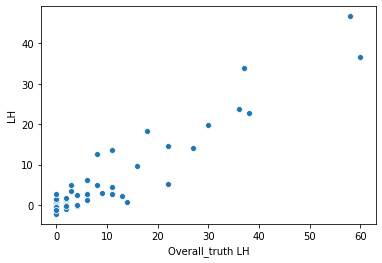

In [14]:
sns.scatterplot(data = merged_df, x="Overall_truth LH",y="LH")

# feet

In [15]:
feet_model = keras.models.load_model("weights/SC1_v3A_feet_narrowing_0.4zerosafter_model_50.h5")

In [16]:
test_dataset_class = combset.overall_test_feet(configuration,"/mnt/jw01-aruk-home01/projects/ra_challenge/RA_challenge/training_dataset/fixed", is_test = True)
test_data = test_dataset_class.create_generator(joints_source= "./data/predictions/feet_joint_data_test_v2.csv")


In [17]:
results = {}

for i in range(1472):
    imgs, img_id = next(test_data)
    res = feet_model.predict(imgs)
    try:
        results[img_id].append(res[0][0])
    except:
        results[img_id] = [res[0][0]]

In [18]:
for item in results:
    results[item] = sum(results[item])/len(results[item])

In [19]:
result = pd.DataFrame.from_dict(results,orient='index')
result.columns = ["Prediction"]
result["patient"] = result.index.str.split("-").str[0]
result["side"] = result.index.str.split("-").str[1]
result = result.pivot(index = "patient", values="Prediction", columns="side")

In [20]:
ground_truth_df = pd.read_csv("/mnt/iusers01/jw01/mdefscs4/ra_challenge/RA_challenge/training_dataset/training.csv")
ground_truth_df = ground_truth_df.set_index("Patient_ID")
what = ".*F.*J.*"
what = re.compile(what)
wanted_cols = list(filter(what.match, ground_truth_df.columns))
merged_df=result.merge(ground_truth_df.loc[:,wanted_cols],how="inner",left_on = "patient", right_index=True)
truth_idx = ["LF_" in x for x in merged_df.columns]
merged_df["Overall_truth LF"] =  merged_df.loc[:,truth_idx].sum(axis = 1)
truth_idx = ["RF_" in x for x in merged_df.columns]
merged_df["Overall_truth RF"] =  merged_df.loc[:,truth_idx].sum(axis = 1)


In [21]:
merged_df[["LF","RF","Overall_truth LF","Overall_truth RF"]]

,LF,RF,Overall_truth LF,Overall_truth RF
patient,,,,
UAB002,-0.090347,0.014936,0,0
UAB018,0.318946,0.147376,0,0
UAB030,1.324349,1.805938,2,2
UAB032,2.188644,0.093094,0,2
UAB036,0.307920,0.074693,0,0
...,...,...,...,...
UAB700,-0.039755,1.366190,0,2
UAB701,1.198906,0.915124,0,0
UAB706,10.466519,8.784992,11,23


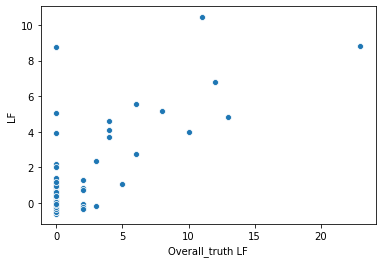

In [22]:
sns.scatterplot(data = merged_df, x="Overall_truth LF",y="LF")